In [9]:
import random
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import average_precision_score, balanced_accuracy_score, f1_score, accuracy_score, roc_auc_score, classification_report, precision_score, recall_score
import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names")


# Read the data from the parquet file
df = pd.read_csv('../../data/heart_failure/train_val_split.csv')
df_test = pd.read_csv('../../data/heart_failure/test_split.csv')


numeric_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
categorical_cols = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']


## Preprocessing

In [10]:
df_clean = df.copy()
    
    
for col in numeric_cols:
    # Calculate Q1, Q3, and IQR
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
        
    # Define bounds
    lower_bound = Q1 - (2 * IQR)
    upper_bound = Q3 + (2 * IQR)
        
    # Create mask for values within bounds
    mask = (df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)
        
    # Apply mask
    df_clean = df_clean[mask]


display(df_clean)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
2,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
3,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
4,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
729,41,M,ATA,120,157,0,Normal,182,N,0.0,Up,0
730,57,F,ASY,140,241,0,Normal,123,Y,0.2,Flat,1
731,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
732,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1


In [11]:
df_clean=pd.get_dummies(df_clean, columns=['ChestPainType','ST_Slope','RestingECG', 'Sex', 'ExerciseAngina'], drop_first=False, dtype=int)
df_test=pd.get_dummies(df_test, columns=['ChestPainType','ST_Slope','RestingECG', 'Sex', 'ExerciseAngina'], drop_first=False, dtype=int)

display(df_clean)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,...,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,Sex_F,Sex_M,ExerciseAngina_N,ExerciseAngina_Y
0,40,140,289,0,172,0.0,0,0,1,0,...,0,0,1,0,1,0,0,1,1,0
1,37,130,283,0,98,0.0,0,0,1,0,...,0,0,1,0,0,1,0,1,1,0
2,48,138,214,0,108,1.5,1,1,0,0,...,0,1,0,0,1,0,1,0,0,1
3,54,150,195,0,122,0.0,0,0,0,1,...,0,0,1,0,1,0,0,1,1,0
4,39,120,339,0,170,0.0,0,0,0,1,...,0,0,1,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,41,120,157,0,182,0.0,0,0,1,0,...,0,0,1,0,1,0,0,1,1,0
730,57,140,241,0,123,0.2,1,1,0,0,...,0,1,0,0,1,0,1,0,0,1
731,45,110,264,0,132,1.2,1,0,0,0,...,0,1,0,0,1,0,0,1,1,0
732,68,144,193,1,141,3.4,1,1,0,0,...,0,1,0,0,1,0,0,1,1,0


In [12]:
y = df_clean['HeartDisease']
X = df_clean.drop(['HeartDisease'], axis=1)

y_test = df_test['HeartDisease']
X_test = df_test.drop(['HeartDisease'], axis=1)

display(X)
display(y)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,Sex_F,Sex_M,ExerciseAngina_N,ExerciseAngina_Y
0,40,140,289,0,172,0.0,0,1,0,0,0,0,1,0,1,0,0,1,1,0
1,37,130,283,0,98,0.0,0,1,0,0,0,0,1,0,0,1,0,1,1,0
2,48,138,214,0,108,1.5,1,0,0,0,0,1,0,0,1,0,1,0,0,1
3,54,150,195,0,122,0.0,0,0,1,0,0,0,1,0,1,0,0,1,1,0
4,39,120,339,0,170,0.0,0,0,1,0,0,0,1,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,41,120,157,0,182,0.0,0,1,0,0,0,0,1,0,1,0,0,1,1,0
730,57,140,241,0,123,0.2,1,0,0,0,0,1,0,0,1,0,1,0,0,1
731,45,110,264,0,132,1.2,0,0,0,1,0,1,0,0,1,0,0,1,1,0
732,68,144,193,1,141,3.4,1,0,0,0,0,1,0,0,1,0,0,1,1,0


0      0
1      0
2      1
3      0
4      0
      ..
729    0
730    1
731    1
732    1
733    1
Name: HeartDisease, Length: 719, dtype: int64

## Training + Validation

In [13]:
# Initialize the MLP classifier
mlp = MLPClassifier(max_iter=1000, random_state=42)

# Dynamically generate hidden_layer_sizes configurations
layer_sizes = [32, 64, 128, 256]
hidden_layer_combinations = []

# Generate architectures with 1 to 3 hidden layers
for num_layers in range(1, 4):
    hidden_layer_combinations.extend(
        [tuple([size] * num_layers) for size in layer_sizes]
    )

# Other hyperparameters to search
alphas = [0.0001, 0.001, 0.01]
learning_rate_inits = [0.0001, 0.001, 0.01]


# Store results
best_params = None
best_score = -np.inf

# Manual hyperparameter tuning
for hidden_layer_sizes in hidden_layer_combinations:
    for learning_rate_init in learning_rate_inits:
        for alpha in alphas:
            fold_scores = []
            
            kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            
            for fold , (train, val) in enumerate(kf.split(X=X,y=y)):
                X_train=X.iloc[train]
                y_train=y.iloc[train]

                X_val=X.iloc[val]
                y_val=y.iloc[val]
                
                scaler = StandardScaler()
                X_train_scaled = X_train.copy()
                X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])

                X_val_scaled = X_val.copy()
                X_val_scaled[numeric_cols] = scaler.transform(X_val[numeric_cols])
                
                # Initialize the MLP with current hyperparameters
                mlp = MLPClassifier(
                    hidden_layer_sizes=hidden_layer_sizes,
                    alpha=alpha,
                    random_state=42,
                    max_iter=1000
                )
                
                # Train and evaluate on the current fold
                mlp.fit(X_train, y_train)
                y_pred = mlp.predict(X_val)
                fold_scores.append(accuracy_score(y_val, y_pred))
            
            # Compute mean accuracy across folds
            mean_score = np.mean(fold_scores)
            
            # Update best parameters if current mean is better
            if mean_score > best_score:
                best_score = mean_score
                best_params = {
                    'hidden_layer_sizes': hidden_layer_sizes,
                    'learning_rate_init': learning_rate_init,
                    'alpha': alpha
                }

# Print the best parameters and score
print("Best parameters found: ", best_params)
print("Best cross-validation accuracy: ", best_score)

Best parameters found:  {'hidden_layer_sizes': (64,), 'learning_rate_init': 0.0001, 'alpha': 0.001}
Best cross-validation accuracy:  0.8817404817404817


In [14]:
# Now use best_params to train final model on full training data
final_scaler = StandardScaler()

# Make a copy of the entire training data
X_scaled = X.copy()
X_scaled[numeric_cols] = final_scaler.fit_transform(X[numeric_cols])

# Train final model
final_model = MLPClassifier(random_state=42, max_iter=1000, **best_params)
final_model.fit(X_scaled, y)

# Scale test data using the same scaler
X_test_scaled = X_test.copy()
X_test_scaled[numeric_cols] = final_scaler.transform(X_test[numeric_cols])

# Make predictions
y_pred = final_model.predict(X_test_scaled)
y_pred_proba = final_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
balanced_acc = balanced_accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred) 
auroc = roc_auc_score(y_test, y_pred_proba)
auprc = average_precision_score(y_test, y_pred_proba)

print(classification_report(y_test, y_pred))
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {auroc:.4f}")
print(f"PRC AUC Score: {auprc:.4f}")

              precision    recall  f1-score   support

           0       0.81      0.76      0.78        74
           1       0.84      0.88      0.86       110

    accuracy                           0.83       184
   macro avg       0.83      0.82      0.82       184
weighted avg       0.83      0.83      0.83       184

Balanced Accuracy: 0.8193
F1 Score: 0.8622
ROC AUC Score: 0.9031
PRC AUC Score: 0.9320


## Visualizing Feature Importance

100%|██████████| 184/184 [00:06<00:00, 28.58it/s]


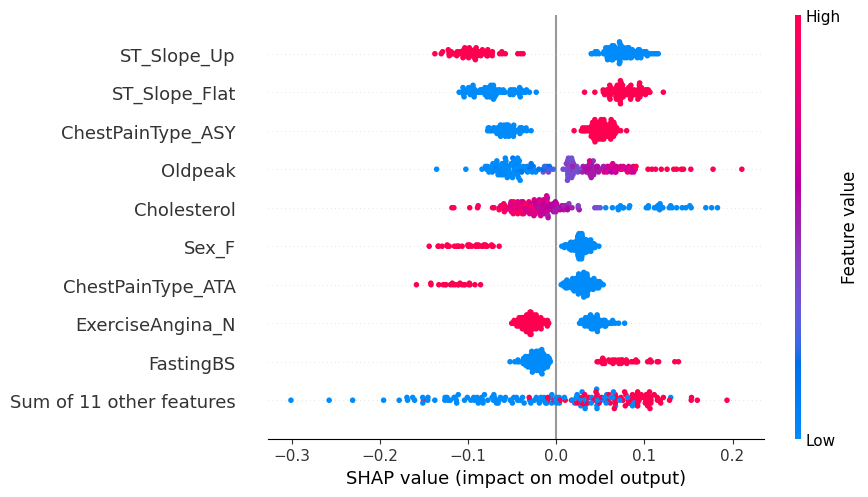

100%|██████████| 4/4 [00:00<00:00, 22.34it/s]


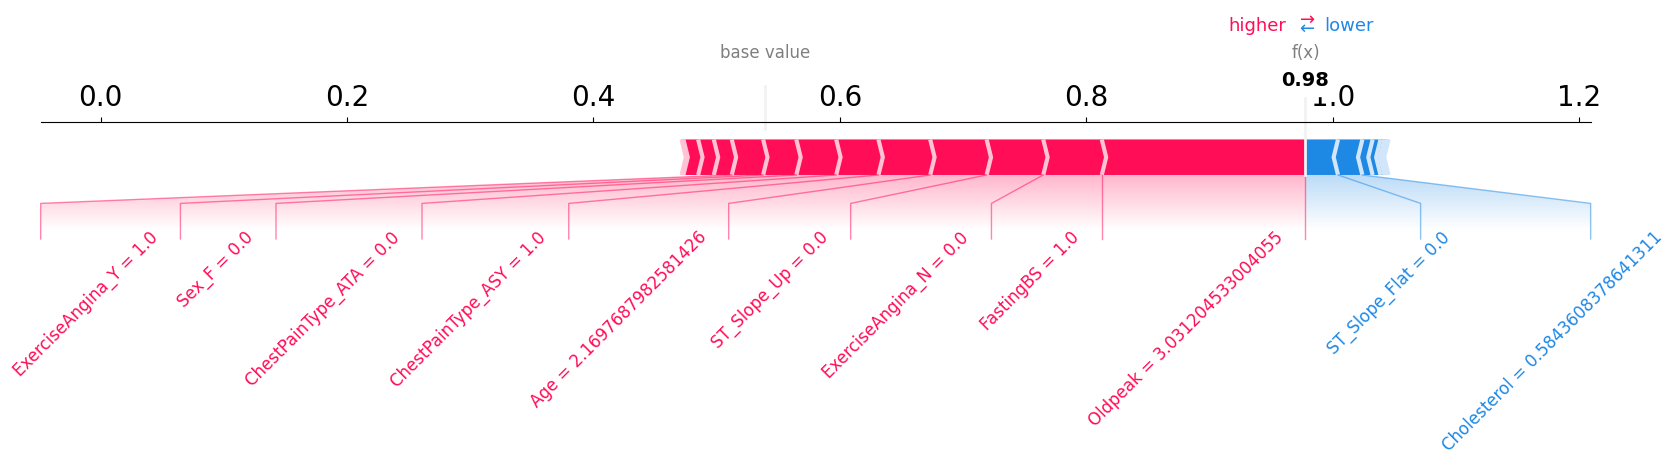

100%|██████████| 4/4 [00:00<00:00, 26.06it/s]


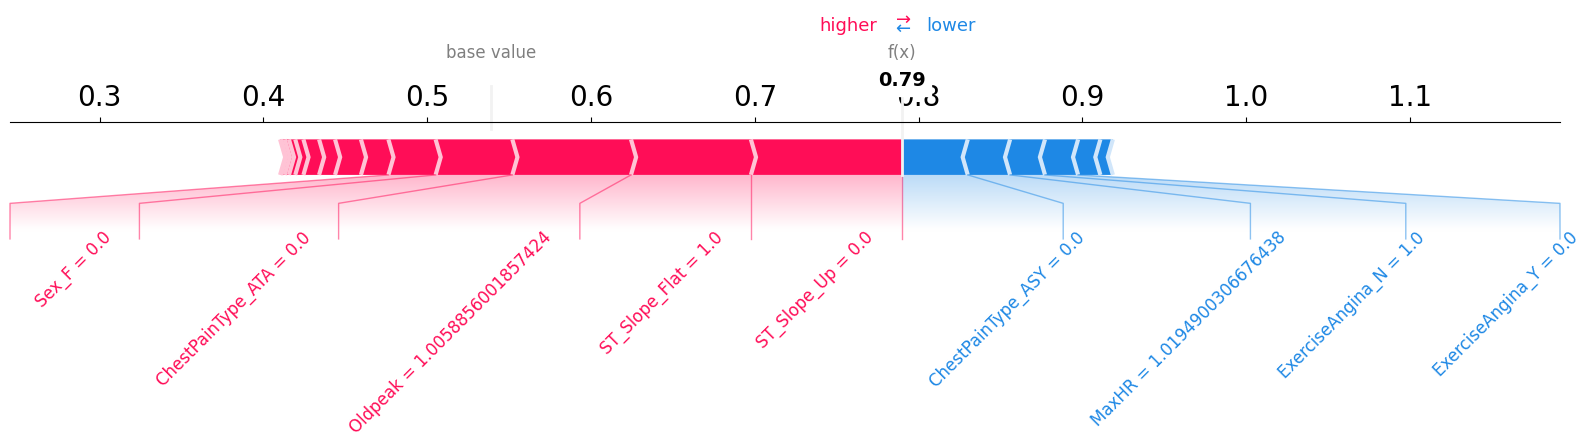

100%|██████████| 4/4 [00:00<00:00, 27.83it/s]


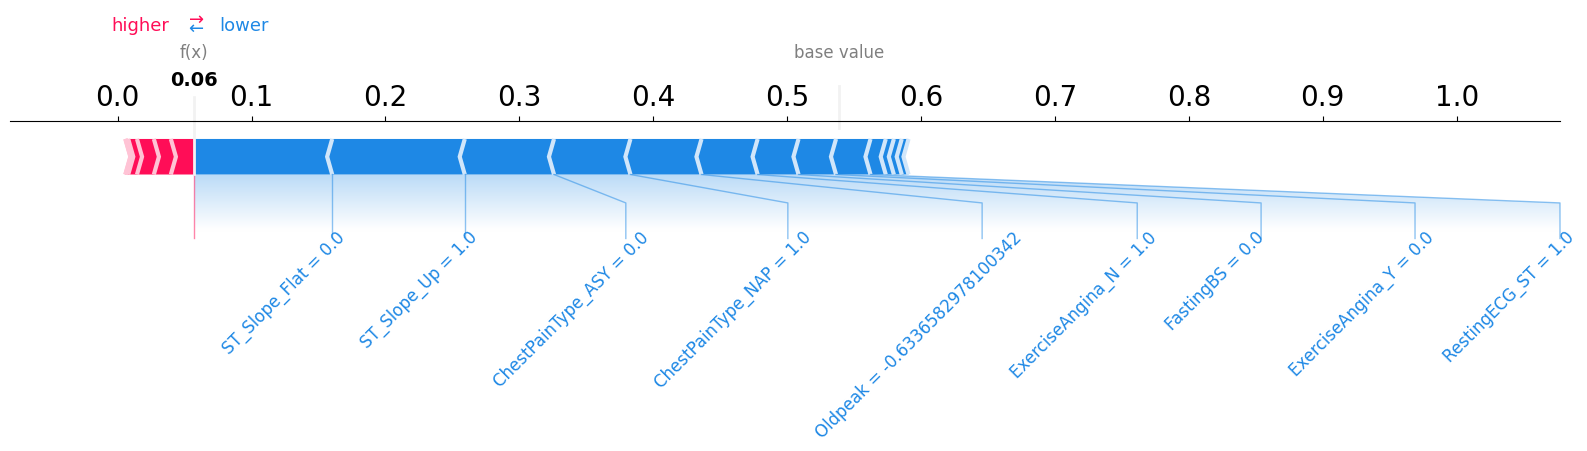

100%|██████████| 4/4 [00:00<00:00, 21.19it/s]


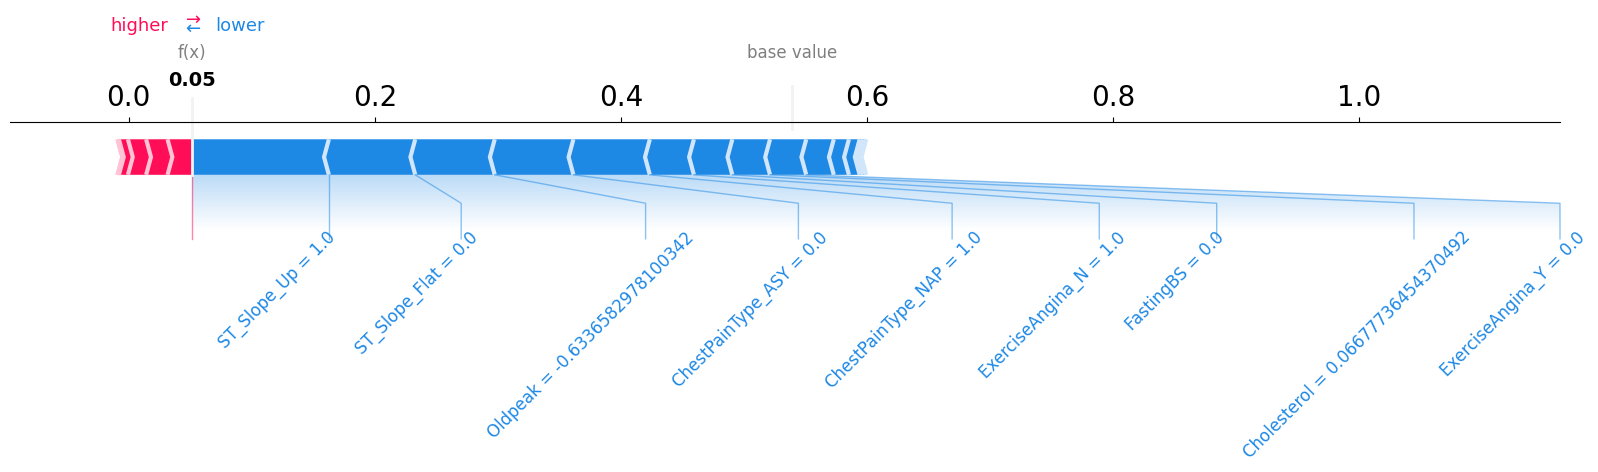

In [15]:
shap.initjs()
random.seed(42)
plt.rcParams.update({'font.size': 20})

# Randomly pick two positive and two negative samples
positive_indices = np.where(y_pred > 0.5)[0]
negative_indices = np.where(y_pred < 0.5)[0]

# Randomly sample two indices from each group
random_positive_indices = random.sample(list(positive_indices), 2)
random_negative_indices = random.sample(list(negative_indices), 2)

# Combine the selected indices
sample_indices = np.concatenate([random_positive_indices, random_negative_indices])
X_sample = X_test_scaled.iloc[sample_indices]

def f(X):
    res = final_model.predict_proba(X)[:, 1].flatten()
    return res

explainer = shap.SamplingExplainer(f, X_train_scaled)
shap_values = explainer.shap_values(X_sample)
shap.force_plot(explainer.expected_value, shap_values, X_sample)
shap.plots.beeswarm(explainer(X_test_scaled))
for i in range(4):
    # shap.waterfall_plot(explainer(X_sample)[i])
    plt.rcParams.update({'font.size': 20})
    shap.plots.force(explainer(X_sample)[i], matplotlib=True,  text_rotation=45)
    # display(shap.plots.text(shap_values[i]))